## 6. Word2Vec - CBoW, SkipGram

In [1]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

data = pd.read_csv('transcripts.csv') #read data
#isnull().sum() : 결측치 (데이터에 값이 없는 것) 값 확인
print('Missing Values: ', data.isnull().sum()) 

data = data.dropna().reset_index(drop = True) #NAN제거 및 기존 index제거

#데이터를 string으로 받아서 합침(merge)
merge_data = ' '.join(str(data.iloc[i,0]) for i in range(100)) #iloc: 행데이터읽기 (첫번째 column에만 배치되어있으므로)
print('Total word count: ', len(merge_data))

print(merge_data[:100]) #한번 확인

/Users/chy/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Missing Values:  transcript    0
url           0
dtype: int64
Total word count:  1511916
Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole th


In [2]:
tokenizer = RegexpTokenizer('[\w]+') #정규표현식 이용(문자 또는 숫자만)
token_text = tokenizer.tokenize(merge_data)

stop_words = set(stopwords.words('english')) #불용어
token_stop_text = []
for w in token_text:
    if w not in stop_words:
        token_stop_text.append(w)
print('After cleaning: ', len(token_stop_text))
print(token_stop_text[:10])

After cleaning:  147300
['Good', 'morning', 'How', 'Laughter', 'It', 'great', 'I', 'blown', 'away', 'whole']


In [3]:
word2inx = {}
Bow = []
#빈도수 확인
for word in token_stop_text:
    if word not in word2inx.keys():
        word2inx[word] = len(word2inx)
        Bow.insert(len(word2inx)-1, 1)
    else:
        inx = word2inx.get(word)
        Bow[inx] += 1

print('Unique Words Count: ', len(Bow))

Unique Words Count:  16689


### 6-2. nltk 내장함수를 이용한 CBoW 학습

In [4]:
import numpy as np
token_stop_text = np.reshape(np.array(token_stop_text), [-1, 1])

from gensim.models import Word2Vec

In [5]:
# vector_size : embedded vector size (hidden feature) --> nn에서 hidden layer (이 경우 100차원)
# window: context window size (참조할 텍스트 수)
# min_count: do not apply word2vec to sparse words (이 경우 2개 미만으로 나오면 버림)
# sg: skip-gram, sg = 0 is sg, sg =1 is CBoW
model = Word2Vec(vector_size = 100, window = 5, min_count = 2, sg = 0)
model.build_vocab(token_stop_text)

model.train(token_stop_text, total_examples = model.corpus_count, epochs = 30) #30번반복
vocabs = model.wv.key_to_index.keys()
word_vec_list = [model.wv[i] for i in vocabs]

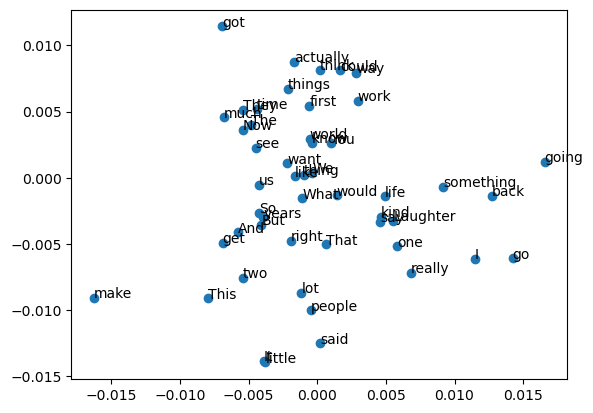

In [6]:
# PCA를 통한 학습 모델 시각화
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) #2차원으로 투영화
pcafit = pca.fit_transform(word_vec_list)
# 단어 50개 가져옴
x = pcafit[0:50, 0]
y = pcafit[0:50, 1]
import matplotlib.pyplot as plt
plt.scatter(x, y, marker = 'o')
for i, v in enumerate(vocabs):
    if i <= 49:
        plt.annotate(v, xy = (x[i], y[i]))
plt.show()

## 7. SGNS: SkipGram with Negative Sampling
#### 7-1. SkipGram 전용 Dataset 구성

In [7]:
# 위 예제에서 사용하던 토큰화와 불용어가 제거된 token_stop_text를 사용

data = pd.read_csv('transcripts.csv') #read data
data = data.dropna().reset_index(drop = True) 
merge_data = ' '.join(str(data.iloc[i,0]) for i in range(100)) 
tokenizer = RegexpTokenizer('[\w]+') #정규표현식 이용(문자 또는 숫자만)
token_text = tokenizer.tokenize(merge_data)
stop_words = set(stopwords.words('english')) #불용어
token_stop_text = []
for w in token_text:
    if w not in stop_words:
        token_stop_text.append(w)
print('After cleaning: ', len(token_stop_text))

After cleaning:  147300


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_stop_text)

word2idx = tokenizer.word_index
encoded = tokenizer.texts_to_sequences(token_stop_text)
encoded = np.array(encoded).T

# dataset setting
from tensorflow.keras.preprocessing.sequence import skipgrams

# text1 text2 label 로 만들어줌
skip_gram = [skipgrams(sample, vocabulary_size = len(word2idx)+1, window_size =10) for sample in encoded]

In [9]:
import torch
import torch.nn as nn
from torch import LongTensor as LT
from torch import FloatTensor as FT

In [10]:
# similarity 를 분석
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        #nn.Embedding: vocab_size와 embed_size(우리 예시에서는 100차원)를 받아옴
        #정수 인코딩된 결과를 넣으면 embedding 결과를 줌
        self.word1_vector = nn.Embedding(self.vocab_size, self.embed_size)
        self.word2_vector = nn.Embedding(self.vocab_size, self.embed_size)
        self.word1_vector.weight = nn.Parameter(torch.cat([torch.zeros(1, self.embed_size), FT(self.vocab_size-1,
                                                                      self.embed_size).uniform_(-0.1, 0.1)]))
        self.word2_vector.weight = nn.Parameter(torch.cat([torch.zeros(1, self.embed_size), FT(self.vocab_size - 1,
                                                                      self.embed_size).uniform_(-0.1, 0.1)]))
        self.word1_vector.weight.requires_grad = True
        self.word2_vector.weight.requires_grad = True
        
    def forward_word1(self, data):
        vec = LT(data)
        vec = vec.cuda() if self.word1_vector.weight.is_cuda else vec
        return self.word1_vector(vec)
    
    def forward_word2(self, data):
        vec = LT(data)
        vec = vec.cuda() if self.word2_vector.weight.is_cuda else vec
        return self.word2_vector(vec)

In [11]:
class SGNS(nn.Module):
    def __init__(self, embed, vocab_size):
        super(SGNS, self).__init__()
        self.embed = embed
        self.vocab_size = vocab_size
        self.weights = None
    def forward(self, word1, word2, label):
        word1 = self.embed.forward_word1(word1).unsqueeze(1) #차원확장
        word2 = self.embed.forward_word2(word2).unsqueeze(2)
        label = LT(label).unsqueeze(1)
        #torch.bmm
        #[B,n,m] X [B,m,p] = [B,n,p]
        prediction = torch.bmm(word1, word2).squeeze(2).sigmoid().log() #차원을 줄어줌
        loss = -label * prediction #cross-entropy 대신
        return loss.mean()

> word1 [B,m] -> [B,1,m] 으로 차원 추가 -> embed </br>
word2 [B,m] -> [B,m,1]으로 차원 추가 -> embed </br>
[B,1,m] X [B,m,1] = [B,1,1] Squeeze 사용하여 [B,1]로 만들고 sigmoid 

In [12]:
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [13]:
vocab_size = len(word2idx) + 1
word2vec = Word2Vec(vocab_size = vocab_size, embed_size = 100)
sgns = SGNS(embed = word2vec, vocab_size = vocab_size)
optim = Adam(sgns.parameters())
print('Train Ready')

Train Ready


In [16]:
for _, element in enumerate(skip_gram):
    word1 = LT(np.array(list(zip(*element[0]))[0], dtype = 'int32'))
    word2 = LT(np.array(list(zip(*element[0]))[1], dtype = 'int32'))
    label = LT(np.array(element[1], dtype = 'int32'))
    dataset = TensorDataset(word1, word2, label)
    train_loader = DataLoader(dataset, batch_size = 256, shuffle = True)
print('Data Loaded')        

Data Loaded


In [17]:
for epoch in range(5):
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for word1, word2, label in tepoch:
            loss = sgns(word1, word2, label)
            optim.zero_grad
            loss.backward()
            optim.step()
            tepoch.set_description(f"Epoch {epoch}")
            tepoch.set_postfix(loss = loss.item())

Epoch 4: 100%|███████████████| 23015/23015 [07:49<00:00, 49.05batch/s, loss=nan]


> label 이 1인애들은 벡터 내적이 줄어드는 방향으로

In [ ]:
# import gensim
# embed_word2vec = gensim.models.KeyedVectors.load_word2vec_format()